# Data Loading

In the first step, we load the required data for our analysis. We read the electric vehicle population data and the census median income data from their respective CSV files.

In [1]:
import pandas as pd

electric_vehicle_population = pd.read_csv("/Users/larsboesch/Documents/UZH/HS24/DataScience/dds_ev_analysis/EV-data.csv")
census_median_income = pd.read_csv("/Users/larsboesch/Documents/UZH/HS24/DataScience/dds_ev_analysis/census-data.csv")

# Clean Vehicle Data

To simplify the column names for easier use in python, we will rename the columns to lowercase and replace spaces with underscores. We will also remove the four rows where the "model" column contains NA values. Additionally, we will create a new column, "vehicle," by combining the "year," "make," and "model" fields.

In [2]:
electric_vehicle_population.columns = electric_vehicle_population.columns.str.lower().str.replace(' ', '_')

electric_vehicle_population_clean = electric_vehicle_population.dropna(subset=['model'])

electric_vehicle_population_clean['vehicle'] = electric_vehicle_population_clean['model_year'].astype(str) + ' ' + electric_vehicle_population_clean['make'] + ' ' + electric_vehicle_population_clean['model']

electric_vehicle_population_clean.head()

,vin_(1-10),county,city,state,postal_code,model_year,make,model,electric_vehicle_type,clean_alternative_fuel_vehicle_(cafv)_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract,vehicle
0,1N4AZ0CP8D,King,Shoreline,WA,98177.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75.0,0.0,32.0,125450447,POINT (-122.36498 47.72238),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303302e+10,2013 NISSAN LEAF
1,5YJSA1E45K,King,Seattle,WA,98112.0,2019,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,270.0,0.0,43.0,101662900,POINT (-122.30207 47.64085),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,2019 TESLA MODEL S
2,WVGUNPE28M,Kitsap,Olalla,WA,98359.0,2021,VOLKSWAGEN,ID.4,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,26.0,272118717,POINT (-122.54729 47.42602),PUGET SOUND ENERGY INC,5.303509e+10,2021 VOLKSWAGEN ID.4
3,JTDKARFP6H,Thurston,Olympia,WA,98501.0,2017,TOYOTA,PRIUS PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25.0,0.0,22.0,349372929,POINT (-122.89166 47.03956),PUGET SOUND ENERGY INC,5.306701e+10,2017 TOYOTA PRIUS PRIME
4,1FADP5CU9G,Thurston,Olympia,WA,98506.0,2016,FORD,C-MAX,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19.0,0.0,22.0,171625653,POINT (-122.87741 47.05997),PUGET SOUND ENERGY INC,5.306701e+10,2016 FORD C-MAX


# Clean Income Data
We are interested in the column `S1903_C03_001E`. To focus on zip codes and income data, we’ll clean the table by extracting zip codes, which are strings starting with “ZCTA5,” and removing the prefix to isolate the zip codes. This will leave us with a simplified table containing two columns: `zip_code` and `median_household_income`. Rows with missing income data are marked with “-”, so we’ll filter those out.

In [3]:
census_median_income_clean = census_median_income.iloc[1:].copy()
census_median_income_clean = census_median_income_clean[['NAME', 'S1903_C03_001E']]
census_median_income_clean = census_median_income_clean.rename(columns={'S1903_C03_001E': 'median_household_income'})
census_median_income_clean = census_median_income_clean.dropna(subset=['median_household_income'])

# Extract zip codes and clean data
census_median_income_clean['zip_code'] = census_median_income_clean['NAME'].str.split(' ').str[-1]
census_median_income_clean = census_median_income_clean[['zip_code', 'median_household_income']]

# Filter out rows with missing income data
census_median_income_clean = census_median_income_clean[census_median_income_clean['median_household_income'] != '-']

census_median_income_clean.head()

,zip_code,median_household_income
1,98001,88962
2,98002,59097
3,98003,59560
4,98004,142173
5,98005,135225


# Investigate Correlation Between Electric Range and Suggested Price

In the next section, we aim to investigate whether there is a correlation between the electric range of vehicles and their suggested price (base MSRP). This analysis will help us understand if vehicles with a higher electric range tend to have a higher suggested price.

In [4]:
# Filter the electric vehicles with base MSRP greater than 0
electric_vehicle_msrp = electric_vehicle_population_clean[electric_vehicle_population_clean['base_msrp'] > 0]

# Remove duplicates based on the 'vehicle' column and select the required columns
electric_vehicle_msrp = electric_vehicle_msrp.drop_duplicates(subset='vehicle')[['vehicle', 'base_msrp', 'electric_range', 'model_year', 'make', 'model']]

electric_vehicle_msrp.head()

,vehicle,base_msrp,electric_range,model_year,make,model
52,2017 BMW 330E,44100.0,14.0,2017,BMW,330E
66,2016 KIA SOUL,31950.0,93.0,2016,KIA,SOUL
132,2014 TESLA MODEL S,69900.0,208.0,2014,TESLA,MODEL S
175,2019 BMW 530E,53400.0,16.0,2019,BMW,530E
252,2012 TESLA MODEL S,59900.0,265.0,2012,TESLA,MODEL S


In [ ]:

Q1 = electric_vehicle_msrp['base_msrp'].quantile(0.25)
Q3 = electric_vehicle_msrp['base_msrp'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = electric_vehicle_msrp[(electric_vehicle_msrp['base_msrp'] < lower_bound) | (electric_vehicle_msrp['base_msrp'] > upper_bound)]

outliers

,vehicle,base_msrp,electric_range,model_year,make,model
9171,2018 PORSCHE PANAMERA,184400.0,14.0,2018,PORSCHE,PANAMERA
43783,2015 PORSCHE 918,845000.0,12.0,2015,PORSCHE,918


In [7]:
# we remove the Porsche 918 from the dataset
electric_vehicle_msrp = electric_vehicle_msrp[electric_vehicle_msrp['model'] != '918']

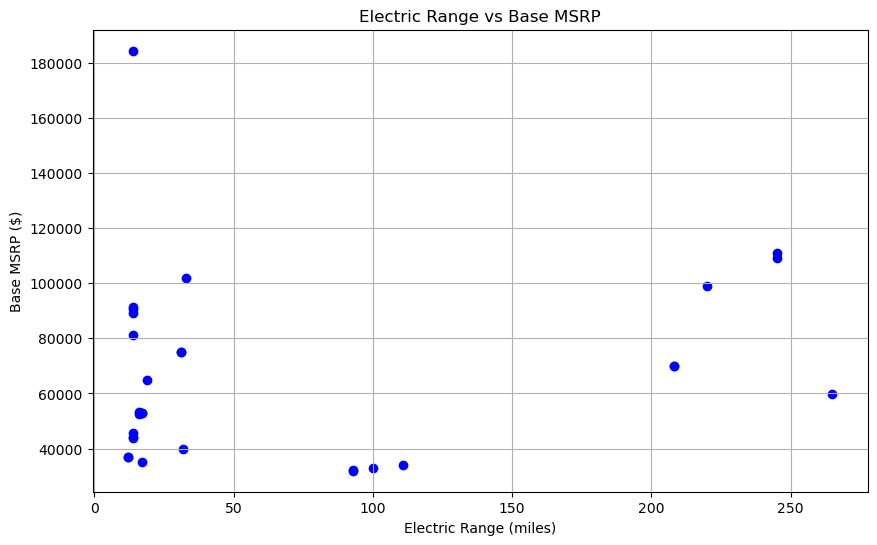

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(electric_vehicle_msrp['electric_range'], electric_vehicle_msrp['base_msrp'], color='blue')
plt.title('Electric Range vs Base MSRP')
plt.xlabel('Electric Range (miles)')
plt.ylabel('Base MSRP ($)')
plt.grid(True)
plt.show()

# Investigate Factors Influencing Units Sold

To understand what factors influence the number of units sold, we will create a new dataset that aggregates the total units sold per vehicle model. This will allow us to analyze the relationship between various attributes (such as electric range, base MSRP, and model year) and the total units sold for each model.

In [13]:
import numpy as np

# Replace 0 values with NaN
electric_vehicle_population_clean['base_msrp'] = electric_vehicle_population_clean['base_msrp'].replace(0, np.nan)
electric_vehicle_population_clean['electric_range'] = electric_vehicle_population_clean['electric_range'].replace(0, np.nan)

# Group by vehicle, electric_range, and base_msrp and count the number of vehicles
electric_vehicle_count = electric_vehicle_population_clean.groupby(['vehicle', 'electric_range', 'base_msrp']).size().reset_index(name='vehicle_n')

# Sort the dataframe by vehicle_n in descending order
electric_vehicle_count = electric_vehicle_count.sort_values(by='vehicle_n', ascending=False)

# Convert to tibble-like format (optional, for display purposes)
electric_vehicle_count = electric_vehicle_count.reset_index(drop=True)
electric_vehicle_count.head()

,vehicle,electric_range,base_msrp,vehicle_n
0,2013 TESLA MODEL S,208.0,69900.0,723
1,2014 TESLA MODEL S,208.0,69900.0,617
2,2016 KIA SOUL,93.0,31950.0,363
3,2017 KIA SOUL EV,93.0,32250.0,142
4,2018 VOLVO XC60,17.0,52900.0,128


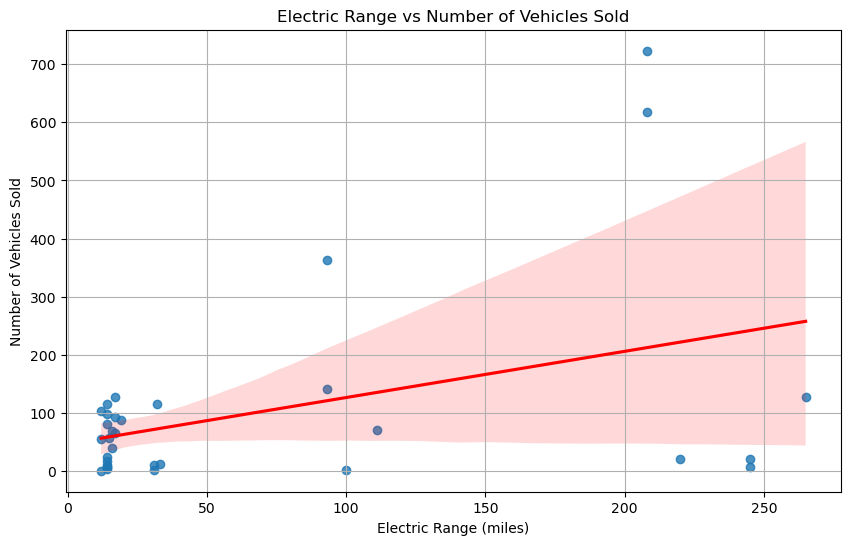

In [14]:
import seaborn as sns
from scipy import stats

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(electric_vehicle_count['electric_range'], electric_vehicle_count['vehicle_n'])

# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x='electric_range', y='vehicle_n', data=electric_vehicle_count, line_kws={'color': 'red'})
plt.title('Electric Range vs Number of Vehicles Sold')
plt.xlabel('Electric Range (miles)')
plt.ylabel('Number of Vehicles Sold')
plt.grid(True)
plt.show()

In [15]:
from scipy.stats import kendalltau

# Perform Kendall correlation test
range_cor, p_value = kendalltau(electric_vehicle_count['electric_range'], electric_vehicle_count['vehicle_n'])

# Display the results
print(f"Kendall correlation coefficient: {range_cor}")
print(f"P-value: {p_value}")

Kendall correlation coefficient: 0.1912198844227032
P-value: 0.13177826559948685


In [ ]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(electric_vehicle_count['base_msrp'], electric_vehicle_count['vehicle_n'])

# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x='base_msrp', y='vehicle_n', data=electric_vehicle_count, line_kws={'color': 'red'})
plt.title('Base MSRP vs Number of Vehicles Sold')
plt.xlabel('Base MSRP ($)')
plt.ylabel('Number of Vehicles Sold')
plt.grid(True)
plt.show()

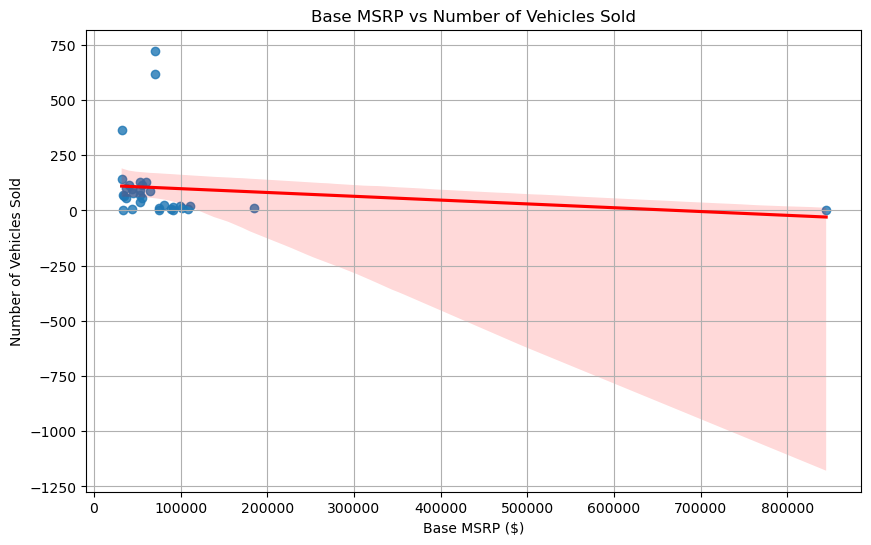

In [17]:
# Perform linear regression
slope_msrp, intercept_msrp, r_value_msrp, p_value_msrp, std_err_msrp = stats.linregress(electric_vehicle_count['base_msrp'], electric_vehicle_count['vehicle_n'])

# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x='base_msrp', y='vehicle_n', data=electric_vehicle_count, line_kws={'color': 'red'})
plt.title('Base MSRP vs Number of Vehicles Sold')
plt.xlabel('Base MSRP ($)')
plt.ylabel('Number of Vehicles Sold')
plt.grid(True)
plt.show()

In [18]:
from scipy.stats import kendalltau

# Perform Kendall correlation test
msrp_cor, p_value_msrp = kendalltau(electric_vehicle_count['base_msrp'], electric_vehicle_count['vehicle_n'])

# Display the results
print(f"Kendall correlation coefficient: {msrp_cor}")
print(f"P-value: {p_value_msrp}")

Kendall correlation coefficient: -0.35271703348011935
P-value: 0.00411940877141904
